<div style="text-align:center;">
    <img src="./Resources/nuvu-logo.svg" alt="logo" width="200" height="175">
</div>

# Informe Tecnico - Exploración de modelos de clasificación

## Análisis Exploratorio y Selección de Modelos con mejorar métricas

En el mundo del análisis de datos y el modelado predictivo, una parte fundamental es comprender en detalle la naturaleza y el comportamiento de los datos con los que estamos trabajando ya que serán el insumo del entrenamiento del modelo. Esto se logra mediante un Análisis Exploratorio de Datos (EDA, por sus siglas en inglés), que nos permite examinar las características de nuestros datos, tanto numéricas como categóricas, y comprender su distribución, tendencias y posibles relaciones entre variables. Esta exploración inicial es crucial para tomar decisiones informadas sobre cómo proceder con el modelado y la predicción.

El objetivo principal de este informe es realizar un EDA exhaustivo de los datos disponibles hasta el momento, con el fin de entender mejor su estructura y características. Esto nos permitirá identificar posibles problemas, como datos faltantes, valores atípicos o distribuciones no esperadas, ver si hay alta multicolinealidad en datos, mirar cómo se comportan las variables categóricas, y tomar medidas para abordarlos de manera efectiva.

Además de la exploración de los datos, también nos proponemos seleccionar los modelos de clasificación más adecuados para nuestro conjunto de datos. Para lograr esto, evaluaremos el rendimiento de tres modelos ampliamente utilizados en la clasificación: Support Vector Machines (SVM), Random Forest Classifier y Gradient Boosting Trees. Estos modelos ofrecen enfoques diferentes para la clasificación y pueden adaptarse a una variedad de situaciones y tipos de datos. En este caso, para extraer la probabilidad de dicha clasificación, que al final de cuentas es el enfoque del proyecto

El proceso de selección de modelos implica entrenar y evaluar cada modelo utilizando métricas específicas, como la precisión (accuracy) y el recall. Además, exploraremos diferentes combinaciones de parámetros (hiperparámetros) para cada modelo, con el objetivo de encontrar la configuración óptima que maximice el rendimiento predictivo.

En resumen, este informe tiene como objetivo realizar un análisis exhaustivo de nuestros datos mediante un EDA detallado, seguido de la selección y evaluación de modelos de clasificación para predecir con precisión las etiquetas de clasificación, y posteriormente su probabilidad. Al finalizar, esperamos haber obtenido una comprensión profunda de nuestros datos y haber identificado el modelo o modelos que mejor se ajusten a nuestras necesidades de estimación.

## Analisis exploratorio de datos (EDA)

### Importación de librerias

In [161]:
# import warnings
# warnings.filterwarnings("ignore")
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.model_selection import train_test_split
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC  # Para clasificación SVM
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score,GridSearchCV,ShuffleSplit
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,recall_score,precision_score,f1_score
from IPython.display import display
# warnings.resetwarnings()

### Fuente de datos

Importamos los conjuntos de datos de entrenamiento que contamos por el momento, provenientes de los archivos Eventos_SI_MM.csv y Eventos_NO_MM.csv proporcionados por SATIC. Estos contienen datos sobre de precipitaciones en diferentes periodos de tiempo, algunas características del suelo y la categorización binaria si hubo un derrumbe o no

A continuación podemos ver la biblioteca de datos de las variables iniciales a tomar en cuenta con su descripción:


| Variable   | Descripción |
|------------|--------|
| ELEVACION | Elevación del punto de movimiento en masa en metros sobre el nivel del mar (msnm) |
| PENDIENT |  Pendiente del punto de movimiento en masa en porcentaje (%) |
| categ_Ries | Nombre de la clasificación de amenaza o riesgo del punto de movimiento en masa |
| COD_COB25_ | Código de la cobertura de suelo Metodologia Land Corine Escala 1:25000 |
| NOM_COB25 | Nombre de la cobertura de suelo Metodologia Land Corine Escala 1:25000 |
| GEOLOGIA_1 | Nomenclatura de la unidad geológica asociada al punto de movimiento en masa |
| 24h | Lluvia acumulada en 24 horas en milímetros |
| 7d | Lluvia acumulada en 7 dias en milímetros |
| 10d | Lluvia acumulada en 10 dias en milímetros |
| 15d | Lluvia acumulada en 15 dias en milímetros |
| 30d | Lluvia acumulada en 30 dias en milímetros |
| 60d | Lluvia acumulada en 60 dias en milímetros |
| 90d | Lluvia acumulada en 90 dias en milímetros |
| deslizamientos | numero que indica si hubo deslizamiento de tierra en el punto de movimiento en masa |

Así mismo, traemos datos nuevos para poder testear el modelo y saber su comportamiento ante datos nunca ha visto, estos son `df_nuevos_datos` y vienen de las consultas a la API de la alcaldia de cali la cual contienen informacion acerca de la precipitacion del suelo que provienen de los sensores en las estaciones alrededor de la ciudad

### Importamos los datos

In [162]:
ruta_data = os.path.join('.', 'Data','output')
data_train='data_train.csv'
data_new='cuadricula_datos_lluvia_activas.json'

In [163]:
# Cargar los datos desde un archivo CSV
df = pd.read_csv(
    os.path.join(ruta_data, data_train)
    )


In [164]:
# Cargar los datos desde un archivo CSV
df_nuevos_datos = gpd.read_file(
    os.path.join(ruta_data, data_new)
    )


Re ordenamos las filas del conjunto de datos de manera aleatoria para asegurar aleatoriedad en el proceso de entrenamiento y seleccion de registros

In [165]:
df=df.sample(frac=1,replace=False,ignore_index=True)

Vemos el conjunto de datos de entrenamiento

In [166]:
df.head()

,ELEVACION,PENDIENT,categ_Ries,COD_COB25_,NOM_COB25,GEOLOGIA_1,24h,7d,10d,15d,30d,60d,90d,deslizamientos
0,976.804382,7.293068,Riesgo bajo,11111,Zonas urbanas continuas,Qca(RMel),0.0,30.9,31.0,50.7,123.8,219.3,331.5,0
1,1002.545227,21.550568,Riesgo bajo,11111,Zonas urbanas continuas,Kv,0.0,75.0,77.0,77.0,221.0,336.0,405.0,0
2,1051.406250,68.581558,Riesgo medio,11111,Zonas urbanas continuas,Kv,14.0,56.0,143.0,233.0,428.0,592.0,750.0,1
3,1072.465820,19.998034,Amenaza baja,23170,Pasto cultivado,TQj,2.0,48.5,52.2,57.0,110.3,240.1,370.4,0
4,1585.298706,98.122704,Riesgo bajo,11211,Zonas urbanas discontinuas,Kv,0.0,26.0,42.0,53.0,93.0,198.0,293.0,1


### Pre-procesamiento

En esta sección se le dará tratamiento a las variables categóricas, dicho tratamiento se trata de la conversión de variables categóricas a números que representan el peso o porcentaje de que ocurra un deslizamiento dada cierta categoría. Esto fue consultado y estipulado por expertos del tema del equipo de SATIC.

Para esto, exportamos los datos de búsqueda (look up data) que nos servirán para extraer los pesos y porcentajes de riesgo por cada categoría


In [167]:
ruta_archivo_lp = os.path.join('Data','input')
ruta_riesgo=os.path.join(ruta_archivo_lp, 'categorizacion_riesgo.csv')
ruta_geologia=os.path.join(ruta_archivo_lp, 'categorizacion_geologia.csv')
ruta_cobsuelo=os.path.join(ruta_archivo_lp, 'categorizacion_coberturasuelo.csv')
lk_riesgo = pd.read_csv(ruta_riesgo)
lk_geologia = pd.read_csv(ruta_geologia)
lk_cobsuelo = pd.read_csv(ruta_cobsuelo)

Vemos las primeras 5 filas de cada tabla de búsqueda, el objetivo es mediante data-joins poder extraer el peso y porcentaje correspondiente

In [168]:
display(lk_riesgo.head(), lk_geologia.head(),lk_cobsuelo.head())

,zonificacion,Categ_Ries
0,Amenaza baja,1
1,Riesgo bajo,2
2,Amenaza media,3
3,Riesgo medio,5
4,Amenaza alta,7


,GEOLOGIA_1,CAT
0,Qca1(RPan),80
1,Qca2(RPan),80
2,Qca(RMel),80
3,Qca,80
4,Qal,80


,COD_COB25_,Categ_CO_2
0,35221,70
1,35210,80
2,32210,30
3,32220,25
4,32211,35


In [169]:
#Cambiamos el nombre de la columna 'categ_Ries' por 'zonificacion' para que haga coincidencia con la tabla de busqueda
df=df.rename(columns={"categ_Ries": "zonificacion"})

Hacemos los joins

In [170]:
df_final = pd.merge(df, lk_riesgo, on='zonificacion', how='left')
df_final = pd.merge(df_final, lk_geologia, on='GEOLOGIA_1', how='left')
df_final = pd.merge(df_final, lk_cobsuelo, on='COD_COB25_', how='left')

In [171]:
df=df_final

Nos deshacemos de las variables categóricas porque ya tenemos los datos numéricos necesarios para el entrenamiento del modelo

In [172]:
df=df.drop(['zonificacion', 'COD_COB25_', 'NOM_COB25','GEOLOGIA_1'],axis=1)

Re-ordenamos las columnas y vemos como nos queda el conjunto de datos de entrenamiento final a utilizar

In [173]:
orden=['ELEVACION', 'PENDIENT','Categ_Ries','CAT','Categ_CO_2', '24h', '7d', '10d', '15d', '30d', '60d', '90d','deslizamientos']
df = df[orden]
df.head()

,ELEVACION,PENDIENT,Categ_Ries,CAT,Categ_CO_2,24h,7d,10d,15d,30d,60d,90d,deslizamientos
0,976.804382,7.293068,2,80,70,0.0,30.9,31.0,50.7,123.8,219.3,331.5,0
1,1002.545227,21.550568,2,20,70,0.0,75.0,77.0,77.0,221.0,336.0,405.0,0
2,1051.406250,68.581558,5,20,70,14.0,56.0,143.0,233.0,428.0,592.0,750.0,1
3,1072.465820,19.998034,1,60,35,2.0,48.5,52.2,57.0,110.3,240.1,370.4,0
4,1585.298706,98.122704,2,20,90,0.0,26.0,42.0,53.0,93.0,198.0,293.0,1


### Parametrización

Como buenas prácticas, empezamos a parametrizar nuestro desarrollo sacando las columnas objetivo, variables a eliminar, variables numéricas y categóricas, etc

In [174]:
independent_var_erase=[]
dependent_var='deslizamientos'
independent_var=[x for x in df.columns if x not in independent_var_erase and x not in dependent_var]

In [175]:
X=df[independent_var]
y=df[dependent_var]

# Seleccionar columnas categoricas
VAR_categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Seleccionar columnas numericas
VAR_numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

# Total de columnas
VAR_cols = VAR_categorical_cols + VAR_numerical_cols

print('Variables categoricas: ',VAR_categorical_cols)
print('Variables numericas: ',VAR_numerical_cols)
print('Variables independientes: ',VAR_cols)

Variables categoricas:  []
Variables numericas:  ['ELEVACION', 'PENDIENT', 'Categ_Ries', 'CAT', 'Categ_CO_2', '24h', '7d', '10d', '15d', '30d', '60d', '90d']
Variables independientes:  ['ELEVACION', 'PENDIENT', 'Categ_Ries', 'CAT', 'Categ_CO_2', '24h', '7d', '10d', '15d', '30d', '60d', '90d']


Observamos que todas las Variables independientes que tomará el modelo son de tipo numéricas, convirtiendo los datos al formato ideal para entrenar un modelo de Machine Learning

### Explorar tendencias

En esta sección el objetivo es identificar posibles problemas, como datos faltantes, valores atípicos o distribuciones no esperadas, ver si hay alta multicolinealidad en datos, mirar cómo se comportan las variables categóricas, comparar modelos de clasificación paramétricos y no paramétricos y tomar medidas para abordarlos de manera efectiva.

Primeramente, es comun en problema de clasificacion revisar si se trata de un problemas de clases desbalanceadas o no.
El desbalance de datos en el aprendizaje automático ocurre cuando hay muchas más muestras de una cosa que de otra. Por ejemplo en este caso, si queremos  detectar deslizamientos de tierra y la mayoría de los registros reportan un no deslizamiento, puede ser difícil para un modelo identificar los deslizamientos porque tiene menos ejemplos para aprender de ellos. Es importante revisar esto al explorar los datos para asegurarse de que el modelo pueda hacer predicciones precisas y útiles. Sin abordar este desbalance, el modelo podría no funcionar correctamente.

Para esto haremos una revision simple de cuantos registros hay de cada clase

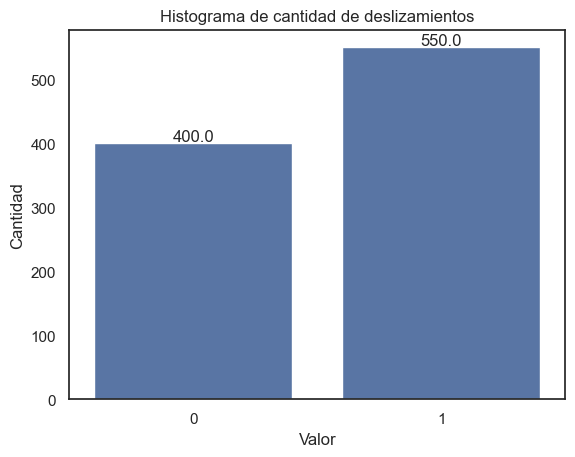

In [176]:
# Grafica el histograma usando Seaborn
ax=sns.countplot(data=df, x='deslizamientos')

# Añade etiquetas y título
plt.xlabel('Valor')
plt.ylabel('Cantidad')
plt.title('Histograma de cantidad de deslizamientos')
# Agrega los valores en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

Como podemos ver, no se presenta un problema grande de desbalance, ya que hay una relación de aproximadamente 40/60 de cada tipo de clase, por lo general se dice que hay desbalance de clases cuando hay una relación 10/90. Pero vemos que este no es el caso 

Ahora se evidencia cómo se comportan ciertas variables numéricas respecto a nuestra variable objetivo, en este caso vemos que tenemos que para puntos de movimiento en masa donde ha habido deslizamientos de tierra, existe mayor cantidad de lluvia acumulada en mm en los últimos 15 días en comparación con los que no han presentado deslizamiento. Esto nos da un indicio de que las variables de precipitación son importantes para estimar si existe deslizamientos o no

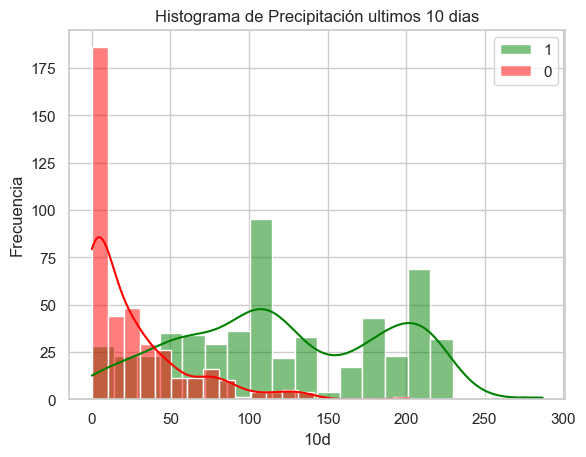

In [177]:
# Configuramos el estilo de Seaborn
sns.set(style="whitegrid")

# Creamos el histograma utilizando Seaborn
sns.histplot(data=df[df['deslizamientos'] == 1],x='10d', bins=20, kde=True, color='green',label='1')
sns.histplot(data=df[df['deslizamientos'] == 0],x='10d', bins=20, kde=True, color='red',label='0')


# Añadimos etiquetas y título
plt.xlabel('10d')
plt.ylabel('Frecuencia')
plt.title('Histograma de Precipitación ultimos 10 dias')
plt.legend()
# Mostramos el histograma
plt.show()

Revisamos si hay valores nulos

In [178]:
#Verificamos si existen valores nulos
df.isnull().sum()

ELEVACION         0
PENDIENT          0
Categ_Ries        0
CAT               0
Categ_CO_2        0
24h               0
7d                0
10d               0
15d               0
30d               0
60d               0
90d               0
deslizamientos    0
dtype: int64

### Correlaciones entre variables independientes

Queremos que haya la menor correlación lineal y no lineal entre las variables independientes, ya que queremos que cada variable aporte su valor único al modelo, y evitar redundancias

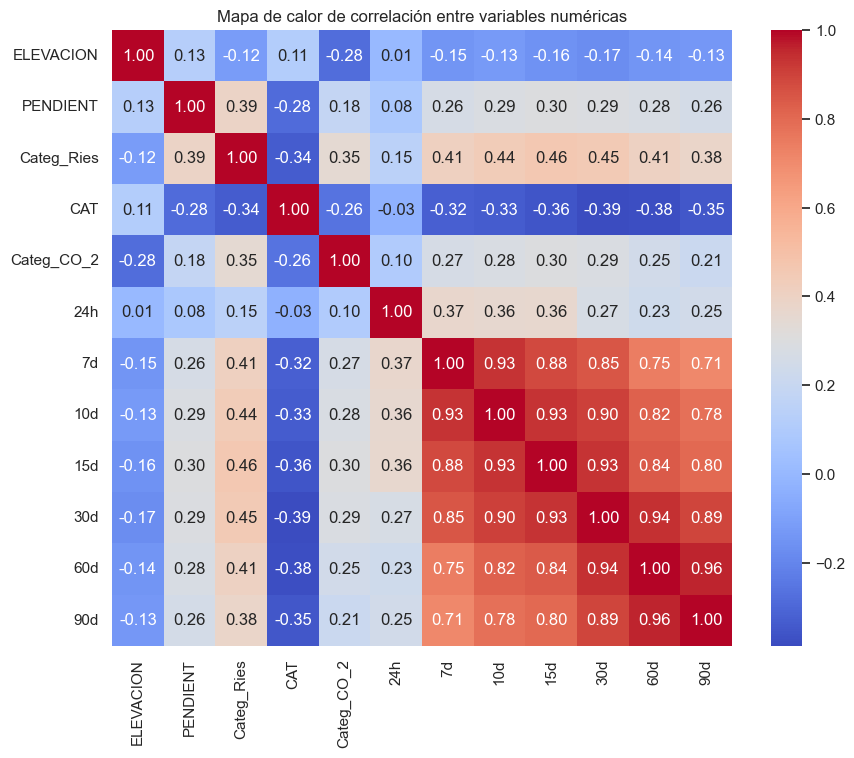

In [179]:
# Correlaciones entre variables independientes
correlation_matrix = X[VAR_numerical_cols].corr(method='pearson')

# Configurar el estilo del mapa de calor
sns.set(style="white")

# Crear el mapa de calor de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Añadir título
plt.title('Mapa de calor de correlación entre variables numéricas')

# Mostrar el mapa de calor
plt.show()

Observamos que existe una alta correlación lineal entre las variables principalmente de precipitación, dándonos a entender que no son del todo independientes y que a medida que suben los dias (10 dias, 15 dias, 30 dias y así sucesivamente) aumenta su dependencia, es decir, lo que explica una variable, ya lo logra a explicar otra.

Se decide continuar con la totalidad de variables y ver como se comportan las métricas de rendimiento dado estos niveles de correlación

## Modelos de aprendizaje automático propuestos

Dentro de los modelos de aprendizaje automático para problemas de clasificación, se encuentran la familia de árboles de decisión, como Decision Trees, Random Forest, XGBoost (estos 2 últimos de ensamble), SVM (support vector machines), entre otros:


- Máquinas de Vectores de Soporte (SVM):

Busca el hiperplano que mejor separa las clases en un espacio multidimensional.

Puede manejar tanto problemas de clasificación lineal como no lineal mediante el uso de diferentes funciones de kernel.

Es eficaz en conjuntos de datos de tamaño moderado a pequeño y es robusto frente a la presencia de ruido.

Este modelo es ideal que el conjunto de datos esté escalador de manera estándar, ya que las diferencias de magnitudes entre diferentes dimensiones puede llegar a afectar el rendimiento


- Árboles de Decisión:

Representa un conjunto de reglas de decisión en forma de árbol.

Es fácil de entender e interpretar, ya que se puede visualizar fácilmente.

Puede manejar datos numéricos y categóricos y es resistente a valores atípicos.


- Bosques Aleatorios (Random Forest):

Consiste en una colección de árboles de decisión, donde cada árbol se entrena con una muestra aleatoria del conjunto de datos.

Reduce el sobreajuste promediando los resultados de múltiples árboles.

Es robusto y puede manejar conjuntos de datos grandes con muchas características.


- XGBoost (Extreme Gradient Boosting Trees):

Implementa un algoritmo de refuerzo de gradiente extremo, que combina múltiples árboles de decisión para mejorar la precisión del modelo de forma secuencial.

Utiliza técnicas avanzadas de regularización y optimización para mejorar la generalización del modelo y evitar el sobreajuste.

Es altamente eficiente y escalable, adecuado para conjuntos de datos grandes y complejos, y es una opción popular en competiciones de ciencia de datos.

<br>
<br>
<br>

## Metodología propuesta

Ahora, la idea es hacer una tubería de datos tal que cuando lleguen los datos nuevos a estimar, estos pasen por las mismas transformaciones por las que pasaron los datos de entrenamiento. Más precisamente hablando, el pipeline en scikit-learn es una herramienta que te permite concatenar varios pasos de procesamiento de datos y modelado en un solo objeto. Esto facilita la construcción, entrenamiento y evaluación de modelos de aprendizaje automático, ya que puedes encapsular todo el flujo de trabajo en una única estructura.


<div style="text-align:center;">
    <img src="./Resources/Resource-Pipeline-CU-Predictor-Favorabilidad-Compra-Acciones.png" alt="logo" width="500" height="225">
</div>

De la misma manera, se busca optimizar las estimaciones y la calidad de los modelos, por lo que se usa la metodología de Grid search o búsqueda de malla para optimizar parámetros dentro de los modelos. Es una herramienta poderosa para optimizar los parámetros de un modelo de aprendizaje automático. Permite definir una cuadrícula de valores para diferentes parámetros del modelo y busca exhaustivamente la mejor combinación de estos parameros, a lo que se le llama hiperparametrizacion.

En términos más simples, el GridSearchCV realiza una búsqueda exhaustiva sobre una cuadrícula de valores especificados para los hiperparámetros de un estimador. Esto permite encontrar la combinación óptima de hiperparámetros que maximiza la precisión o cualquier otra métrica de evaluación definida.

La idea detrás del GridSearchCV es que, en lugar de ajustar manualmente los hiperparámetros del modelo y evaluar su rendimiento, el proceso se automatiza y se realiza de manera sistemática. Esto ahorra tiempo y esfuerzo, ya que el GridSearchCV evalúa todas las combinaciones posibles de los hiperparámetros dentro de la cuadrícula especificada y selecciona la mejor combinación según la métrica de evaluación especificada.


<div style="text-align:center;">
    <img src="./Resources/Grid_serach.png" alt="logo" width="500" height="225">
</div>

Por último, se propone usar validación cruzada aleatoria y dividida. Esto con el proposito de no usar la clasica division unitaria de entrenamiento-pruba, ya que en este tipo de división el entrenamiento o aprendizake del modelo puede quedar sesgado debido a que al dividir aleatoriamente no sabemos con que proporción de los datos el modelo aprende, por ejemplo, al dividir una sola vez el conjunto de datos nos puede quedar que en el conjunto de test solo haya valores con el label de 0 (no deslizamiento en este caso) y en el entrenamiento solo existan registros del label 1 (deslizamientos), esto puede ocasionar que el modelo no aprenda de la manera más optima.

Con la validación cruzada aleatoria y dividida (shuffle-split). En la validación cruzada de división aleatoria, cada división (split) está compuesta de tanto train_size puntos (disyuntos) para el conjunto de entrenamiento y tantos test_size puntos (disjuntos) para el conjunto de prueba, se fijen inicialmente. Esta división se repite n veces, de forma aleatoria. Por ejemplo en la siguiente imagen, para la ejecución de cuatro iteraciones de división de un conjunto de datos que consta de 10 puntos, con un conjunto de entrenamiento de 5 puntos y conjuntos de prueba de 2 puntos cada uno


<div style="text-align:center;">
    <img src="./Resources/shuffle_split.png" alt="logo" width="800" height="200">
</div>

### Métricas de Evaluación propuestas

En el desarrollo de nuestro modelo de clasificación binaria para la identificación de zonas propensas a deslizamientos de tierra, enfrentamos una decisión crucial en la selección de la métrica de rendimiento a optimizar. La esencia de nuestra clasificación distingue dos categorías claves: la clase positiva (1), que indica la presencia de un deslizamiento de tierra, y la clase negativa (0), que señala su ausencia.





<div style="text-align:center;">
    <img src="./Resources/matriz_confusion_ejemplo.png" alt="logo" width="400" height="300">
</div>

Si vemos la anterior matriz de confusió, para nuestro análisis, es vital priorizar la reducción de los falsos negativos (FN - false negatives), es decir, las situaciones donde el modelo predice erróneamente que no habrá deslizamiento de tierra cuando en realidad sí ocurre. La ocurrencia de estos errores podría tener consecuencias significativas en términos de seguridad y preparación ante desastres naturales.



#### Tipos de métricas

**Accuracy**

Ya vimos una forma de resumir el resultado en la matriz de confusión, calculando su accuracy, que puede expresarse como

$$ \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $$

En otras palabras, el accuracy es el número de predicciones correctas (TP y TN) dividido por el número de todas las muestras (todas las entradas de la matriz de confusión sumadas).


**Precision**

Precision mide cuántas de las muestras predichas como positivas son realmente positivas, es decir, precision intenta responder a la siguiente pregunta: ¿qué proporción de identificaciones positivas fue correcta?

$$ \text{Precision} = \frac{TP}{TP + FP} $$

Precision se utiliza como métrica de rendimiento cuando el objetivo es limitar el número de falsos positivos.


**Recall**

El recall mide cuántas de las muestras de la clase positiva son realmente predichas positivas, es decir, recall intenta responder a la siguiente pregunta: ¿qué proporción de positivos reales se identificó en forma correcta?

$$ \text{Recall} = \frac{TP}{TP + FN} $$

Recall se utiliza como métrica de rendimiento cuando el objetivo es limitar el número de falsos negativos.

**F1-score**

F1-score extrae una medida de combinada de la precisión y el recall en un solo número, proporcionando una medida general del rendimiento del modelo. Es la media armónica de la precisión y el recall, la media armónica da más peso a los valores más bajos, por lo que el F1-score será alto solo si tanto la precisión como el recall son altos.

$$ F1 = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} $$

Con este objetivo en mente, la métrica que hemos decidido optimizar es el recall (también conocido como sensibilidad). El recall mide la capacidad del modelo para identificar correctamente los verdaderos casos positivos de deslizamientos de tierra entre todos los casos reales. Un recall alto implica que el modelo es efectivo en la detección de la mayoría de los eventos de deslizamientos, minimizando así el riesgo de no alertar sobre posibles desastres.

Optimizar el recall, sin embargo, puede llevar a un incremento en los falsos positivos —predicciones incorrectas de deslizamientos donde no ocurrirán—. Aunque esto podría considerarse un costo menor en comparación con los riesos de omitir alertas reales, es crucial implementar un equilibrio adecuado con la precisión, que mide la proporción de predicciones positivas correctas entre todas las predicciones positivas realizadas por el modelo.

Nuestra estrategia para calibrar el modelo se centra en maximizar el recall para asegurar una efectiva detección de todos los potenciales deslizamientos de tierra, mientras mantenemos un nivel aceptable de precisión para limitar las falsas alarmas. Esta aproximación está diseñada para ofrecer la máxima protección y preparación, alineándose con las prioridades de seguridad y respuesta ante emergencias de nuestra comunidad.

## Desarrollo

Dividimos el conjunto de datos de entrenamiento de manera aleatoria y dividida, entrenando con 60% de los registros y testeando con el 40% de los registros en cada 10 split. Pero antes sacamos un conjunto de datos de Validación para medir rendimientos

In [180]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2)

In [181]:
shuffle_split = ShuffleSplit(test_size=.4, train_size=.6, n_splits=10)

### Modelo Support Vector Machines

Definimos la variable `preprocessor_svc` que contiene el preprocesamiento de datos que necesita un modelo de Support Vector Machines, acá buscamos estandarizar los datos a bajo una misma unidad de medida con la función de `StandardScaler()` que toma los datos y los transforma para que todos estén en una misma escala, como si los pusieras todos en la misma unidad de medida


In [182]:
# Paso 1: Define el preprocesamiento de datos
preprocessor_svc = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), VAR_numerical_cols)
    ],
    remainder='passthrough'
)

Con el objetivo de hacer un grid search (búsqueda de malla), para hiper parametrizar este modelo de SVM, se define `param_grid_svc`, que contiene diferentes combinaciones de parámetros para el modelo de Support Vector Machines

In [183]:
param_grid_svc={'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf','sigmoid'],'classifier__gamma':[0.01, 0.1, 1]}

El pipeline,como se explicó anteriormente, se utiliza para dejar encapsulado los pasos de preprocesamientos necesario previos a la estimación. Asi, al estimar con este objeto tipo `Pipeline` nos aseguramos de que los nuevos datos sin procesar se reprocesen antes de la estimación nueva

In [184]:
pipeline_svc = Pipeline([
        ('preprocessor', preprocessor_svc),
        ('classifier', SVC())
    ])

Utilizamos GridSearchCV para hacer todas las combinaciones posibles y buscar los mejores parámetros.

Como vemos, tenemos `scoring='recall'`, lo que significa que este objeto hará el entrenamiento y la validación cruzada buscando optimizar esta medida, que se propuso previamente

In [185]:
grid_search_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=shuffle_split, scoring='recall')

Entrenamos el modelo con el método `.fit()`

In [186]:
ajuste_svc=grid_search_svc.fit(X_train, y_train)

Imprimir los resultados

In [187]:

print("Modelo ganador Support Vector Machines:", ajuste_svc.best_estimator_)
print("Mejor combinación de parámetros:", ajuste_svc.best_params_)
print("Puntaje de recall (recuperación) en el conjunto de entrenamiento:", ajuste_svc.best_score_)

Modelo ganador Support Vector Machines: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['ELEVACION', 'PENDIENT',
                                                   'Categ_Ries', 'CAT',
                                                   'Categ_CO_2', '24h', '7d',
                                                   '10d', '15d', '30d', '60d',
                                                   '90d'])])),
                ('classifier', SVC(C=0.1, gamma=1))])
Mejor combinación de parámetros: {'classifier__C': 0.1, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}
Puntaje de recall (recuperación) en el conjunto de entrenamiento: 1.0


### Modelo Random Forest y Gradient Boosting Classifier

Estos 2 modelos se desarrollan juntos ya que tienen el mismo preprocesamientos de datos, a diferencia de del Support Vector Machines que necestia un preprosesamiento diferente

Definimos nuestro diccionario de clasificadores. Acá buscamos dejar en una estructura los 2 tipos de clasificadores que usaremos

In [188]:
classifiers = {
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier()
}

Con el objetivo de hacer un grid search (busqueda de malla), para hiper parametrizar cada uno de las 2 clases de clasificadores de la familia de arboles, se define `param_grid`, que contiene diferentes combinaciones de parametros para cada uno de los 2 modelos

In [189]:
param_grid = {
    'RandomForestClassifier': {'classifier__n_estimators': [100,250,500], 'classifier__max_depth': [None, 10, 20],'classifier__min_samples_split': [2, 5, 10],'classifier__min_samples_leaf': [1, 2, 4]},
    'GradientBoostingClassifier': {'classifier__n_estimators': [100,250,500], 'classifier__learning_rate': [0.01, 0.1, 0.2], 'classifier__max_depth': [None, 10, 20],'classifier__min_samples_split': [2, 5, 10]}
}

Inicializamos la variable preprocessor que nos va a transformar los datos en el pipeline antes de pasarlos al estimador, en este caso, transforma los valores nulos a 0

In [190]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='constant', fill_value=0), VAR_numerical_cols)
    ],
    remainder='passthrough'
)

Ahora juntamos los 2 pasos anteriores para hacer un pipeline para cada tipo de modelo. El pipeline se utiliza para dejar encapsulado los pasos de preprocesamientos necesario previos a la estimación. Asi, al estimar con este objeto tipo `Pipeline` nos aseguramos de que los nuevos datos sin procesar se reprocesen antes de la estimación nueva

In [191]:
# Definir un diccionario de pipelines
pipelines = {}
for name, classifier in classifiers.items():
    pipelines[name] = Pipeline([
        ('preprocessor',preprocessor),
        ('classifier', classifier)
    ])

In [192]:
pipelines

{'RandomForestClassifier': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('num',
                                                   SimpleImputer(fill_value=0,
                                                                 strategy='constant'),
                                                   ['ELEVACION', 'PENDIENT',
                                                    'Categ_Ries', 'CAT',
                                                    'Categ_CO_2', '24h', '7d',
                                                    '10d', '15d', '30d', '60d',
                                                    '90d'])])),
                 ('classifier', RandomForestClassifier())]),
 'GradientBoostingClassifier': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('num',
                                      

Con este ciclo buscamos entrenar cada modelo para hacer todas las combinaciones posibles y buscar los mejores parámetros

In [193]:
# import warnings
# warnings.filterwarnings("ignore")
best_models = {}
for name, pipeline in pipelines.items():
    grid_search2 = GridSearchCV(pipeline, param_grid[name], cv=shuffle_split,scoring='recall')
    grid_search2.fit(X_train, y_train)
    msg_training=f"Rendimiento en training -> {name} \n Puntaje recall en entrenamiento: {grid_search2.best_score_}, \n modelo ganador: {grid_search2.best_estimator_} \n mejor combinacion de parametros: {grid_search2.best_params_}"
    print(msg_training)
    best_models[name] = grid_search2.best_estimator_

# warnings.resetwarnings()

Rendimiento en training -> RandomForestClassifier 
 Puntaje recall en entrenamiento: 0.9605732261385281, 
 modelo ganador: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['ELEVACION', 'PENDIENT',
                                                   'Categ_Ries', 'CAT',
                                                   'Categ_CO_2', '24h', '7d',
                                                   '10d', '15d', '30d', '60d',
                                                   '90d'])])),
                ('classifier', RandomForestClassifier())]) 
 mejor combinacion de parametros: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2

Acá podemos ver un diccionario que contiene los modelos ganadores para cada tipo, es decir,un modelo ganador para Support Vectors Machines, un ganador de RandomForest y otro ganador de GradientBoostingClassifier. Arriba podemos ver como le fue a cada uno en training

In [194]:
best_models['SVC']=ajuste_svc.best_estimator_

In [195]:
print(best_models)

{'RandomForestClassifier': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['ELEVACION', 'PENDIENT',
                                                   'Categ_Ries', 'CAT',
                                                   'Categ_CO_2', '24h', '7d',
                                                   '10d', '15d', '30d', '60d',
                                                   '90d'])])),
                ('classifier', RandomForestClassifier())]), 'GradientBoostingClassifier': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  S

Acá buscamos saber cual de esas 3 clases de modelo diferentes tiene mejor rendimiento en recall, para eso los probamos con el conjunto de datos de validación visto anteriormente y obtenemos sus puntajes

In [196]:
# import warnings
# warnings.filterwarnings("ignore")
# Evaluación de rendimiento en el conjunto de prueba
test_accuracies = {}
for name, model in best_models.items():
    y_pred = model.predict(X_valid)
    accuracy = recall_score(y_valid, y_pred)
    test_accuracies[name] = accuracy
    print(f"Recall en test para {name}: {accuracy}")

# warnings.resetwarnings()

Recall en test para RandomForestClassifier: 0.9702970297029703
Recall en test para GradientBoostingClassifier: 0.9405940594059405
Recall en test para SVC: 0.9900990099009901


Podemos observar que tanto para la etapa de entrenamiento y prueba, los modelos que presentan medidas más generalizadas y óptimas son los de la familia de árboles de clasificación como el RandomForestClassifier y el GradientBoostingClassifier. Vemos que el modelo de Support Vector Machines para la medida del recall se comporta de una manera muy ajustada, tanto que da 100%, esto hace que el modelo no sea óptimo para el consumo de estimaciones.

Dadas estas medidas de recall, escogeremos el modelo de RandomForestClassifier como el mejor modelo, a continuación podemos ver sus parámetros

In [197]:
the_best_model=best_models['RandomForestClassifier']

the_best_model
print(f"\nEl mejor modelo es: {the_best_model.named_steps['classifier']} \n con un recall en test de {test_accuracies['RandomForestClassifier']}")


El mejor modelo es: RandomForestClassifier() 
 con un recall en test de 0.9702970297029703


Miramos el reporte de métricas completas

In [198]:
# import warnings
# warnings.filterwarnings("ignore")
# Calcular las métricas para el SVC
y_pred_1 = best_models['SVC'].predict(X_valid)
precision1 = precision_score(y_valid, y_pred_1)
recall1 = recall_score(y_valid, y_pred_1)
accuracy1 = accuracy_score(y_valid, y_pred_1)
f1_score1 = f1_score(y_valid, y_pred_1)

# Calcular las métricas para el RandomForest
y_pred2 = best_models['RandomForestClassifier'].predict(X_valid)
precision2 = precision_score(y_valid, y_pred2)
recall2 = recall_score(y_valid, y_pred2)
accuracy2 = accuracy_score(y_valid, y_pred2)
f1_score2 = f1_score(y_valid, y_pred2)

# Calcular las métricas para el XGBoost
y_pred3 = best_models['GradientBoostingClassifier'].predict(X_valid)
precision3 = precision_score(y_valid, y_pred3)
recall3 = recall_score(y_valid, y_pred3)
accuracy3 = accuracy_score(y_valid, y_pred3)
f1_score3 = f1_score(y_valid, y_pred3)

# warnings.resetwarnings()

In [199]:
data_reporte = {
    'Modelo': ['Support Vector Classifier', 'Random Forest Classifier', 'XGBoost Classifier'],
    'Precisión (Precision)': [precision1, precision2, precision3],
    'Sensibilidad (Recall)': [recall1, recall2, recall3],
    'Exactitud (Accuracy)': [accuracy1, accuracy2, accuracy3],
    'F1-score': [f1_score1, f1_score2, f1_score3]
}

df_reporte = pd.DataFrame(data_reporte)

## Resumen rendimiento de modelos

In [200]:
df_reporte

,Modelo,Precisión (Precision),Sensibilidad (Recall),Exactitud (Accuracy),F1-score
0,Support Vector Classifier,0.666667,0.990099,0.731579,0.796813
1,Random Forest Classifier,0.989899,0.970297,0.978947,0.980000
2,XGBoost Classifier,0.969388,0.940594,0.952632,0.954774


Esta tabla de resumen de rendimientos, nos permite ver de manera global el comportamiento de los modelos de clasificación.

Para el Support Vector Classifier vemos que tiene un sobre-ajuste en la medida de Sensibilidad (Recall), su Precisión (Precision) y Exactitud (Accuracy) es moderada en comparación con otros modelos. Aunque tiene una sensibilidad perfecta, su precisión es significativamente menor en comparación con los otros modelos. Esto sugiere que podría estar clasificando demasiados casos como positivos, lo que podría resultar en un mayor número de falsos positivos.

Respecto al Random Forest Classifier tiene la mayor precisión entre los tres modelos, lo que sugiere que es más selectivo al clasificar los casos positivos y minimiza los falsos positivos. Aunque tiene una sensibilidad ligeramente menor que el SVC, aún es bastante alta, lo que indica que el modelo puede identificar la mayoría de los casos positivos. La Exactitud (Accuracy) es la más alta entre los tres modelos, lo que sugiere que es más robusto en la clasificación en general.

Por último para el XGBoost Classifier notamos que tiene una precisión y una exactitud ligeramente más bajas que Random Forest, pero aún así son bastante altas. Aunque la sensibilidad es similar a Random Forest y SVC, el modelo podría ser menos consistente en la identificación de casos positivos en comparación con Random Forest, dado su F1-score ligeramente más bajo. El XGBoost Classifier es conocido por su capacidad para manejar datos desbalanceados y su rendimiento generalmente es competitivo en comparación con otros algoritmos de clasificación.


Se concluye que el modelo a utilizar para las estimaciones Random Forest Classifier, debido a su buena generalización y versatilidad respecto a los demás modelos

## Visibilidad y entendimiento del modelo

En esta sección buscamos entender cómo son los modelos por dentro.

El "feature importance" (importancia de las características) en un modelo de aprendizaje automático, indica cuánto contribuye cada característica (o atributo) al rendimiento general del modelo en la tarea de predicción. Es una medida útil para entender qué características son más relevantes para la predicción de la variable objetivo. Lo realizamos para los modelos de la familia de arboles de decisión ya que estos modelos registran el peso de cada variable independiente

En este caso para el RandomForestClassifier, podemos ver que la variable `Categ_Ries` (peso de la clasificación de amenaza o riesgo del punto de movimiento en masa), `15d` (precipitación acumulada en los últimos 15 días en mm) y `10d` (precipitación acumulada en los últimos 10 dias en mm) aportan aproximadamente más del 50% en la estimación del deslizamiento, dando a entender que son variables importante si se quiere estimar si hay deslizamientos o no


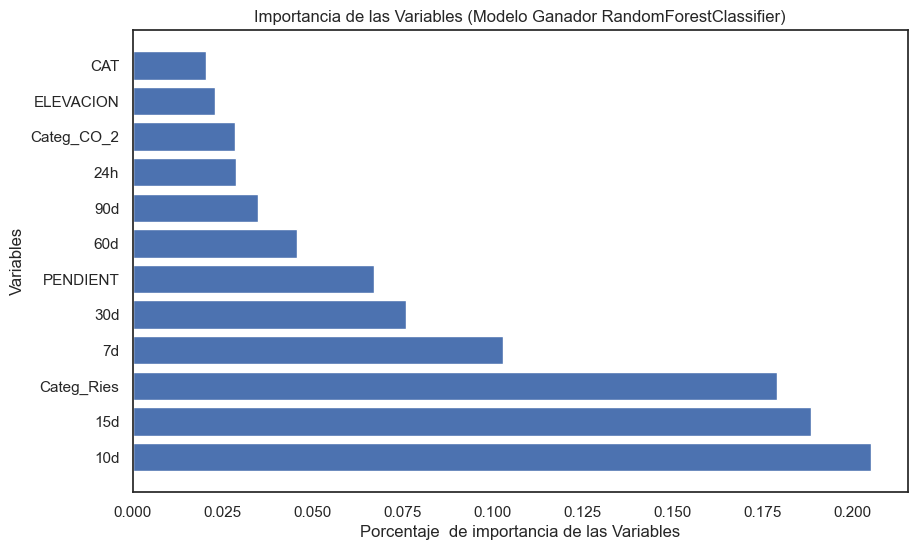

In [201]:
# Obtener la importancia de las características
feature_importances = best_models['RandomForestClassifier']['classifier'].feature_importances_

# Obtener los nombres de las características
feature_names = X_train.columns  # Reemplaza esto con el nombre de tus características si tienes

# Ordenar las características por su importancia
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances)
plt.xlabel('Porcentaje  de importancia de las Variables')
plt.ylabel('Variables')
plt.title('Importancia de las Variables (Modelo Ganador RandomForestClassifier)')
plt.show()

Ahora para el GradientBoostingClassifier, se vuelven a repetir las variables `Categ_Ries` (peso de la clasificación de amenaza o riesgo del punto de movimiento en masa) y `15d` (precipitación acumulada en los últimos 15 días en mm) aportando aproximadamente 70% en la estimación del deslizamiento. 

Notamos que Gradient Boosting le da muchísimo más peso a pocas variables, esto es porque este modelo al ser una versión optimizada del Random Forest, logra hacer lo mismo con menos variables de entrada

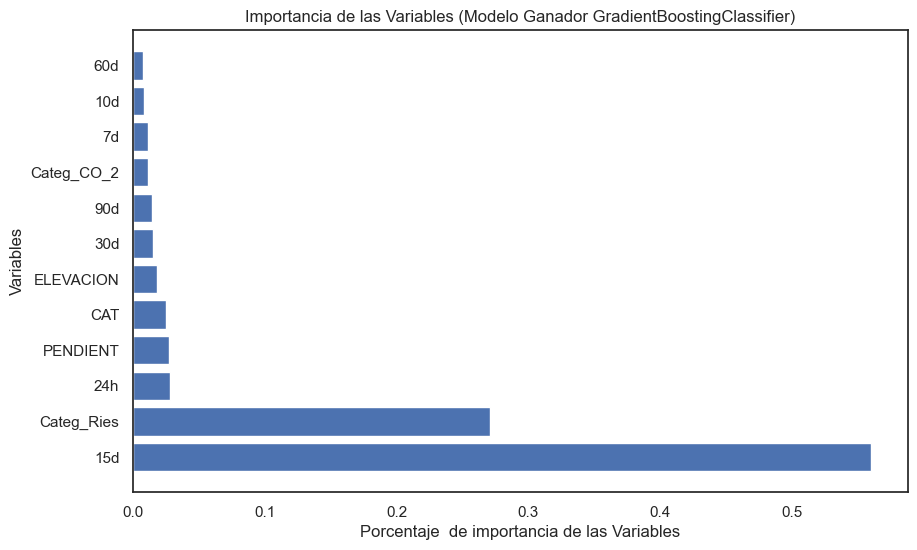

In [202]:
# Obtener la importancia de las características
feature_importances = best_models['GradientBoostingClassifier']['classifier'].feature_importances_

# Obtener los nombres de las características
feature_names = X_train.columns  # Reemplaza esto con el nombre de tus características si tienes

# Ordenar las características por su importancia
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances)
plt.xlabel('Porcentaje  de importancia de las Variables')
plt.ylabel('Variables')
plt.title('Importancia de las Variables (Modelo Ganador GradientBoostingClassifier)')
plt.show()

## Aplicación del modelo

Hemos visto cómo funcionan los modelos para clasificar, pero el objetivo de este caso de uso es estimar probabilidades de cada clase, en este caso, la probabilidad de que ocurra un deslizamiento de tierra o no.

Para esto, python y el paquete de scikit-learn nos ofrecen un método llamado `predict_proba()` que podemos llamar una vez tengamos un modelo entrenado.
Una vez que el modelo está entrenado,  puede ser consumido para hacer predicciones sobre datos nuevos o no vistos. Cuando se llama al método predict_proba() en una instancia de RandomForestClassifier, el modelo pasa la instancia a través de todos los árboles de decisión en el bosque y recopila las predicciones de cada árbol.

Para cada clase, el método calcula la fracción de árboles de decisión en el bosque que predice esa clase para la instancia dada. Estas fracciones se pueden interpretar como probabilidades. Por ejemplo, si hay 100 árboles en el bosque y 70 de ellos predicen que una instancia pertenece a la clase 1, entonces la probabilidad estimada de que la instancia pertenezca a la clase 1 sería 0.7.

Esto proporciona una estimación de la probabilidad de que una instancia dada pertenezca a cada una de las clases en el problema de clasificación, es decir, si existe deslizamiento de tierra o no. Esto es útil cuando necesitas no solo la clase predicha, sino también la probablidad en esa estimación, como es este caso.

In [203]:
the_best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['ELEVACION', 'PENDIENT',
                                                   'Categ_Ries', 'CAT',
                                                   'Categ_CO_2', '24h', '7d',
                                                   '10d', '15d', '30d', '60d',
                                                   '90d'])])),
                ('classifier', RandomForestClassifier())])

In [204]:
# Definir función para predecir probabilidades 
def predecir_probabilidades(df_nuevos_datos, modelo, columnas):
    df_predict=df_nuevos_datos[columnas]
    # Predecir probabilidades
    probabilidades = modelo.predict_proba(df_predict)[:,1]
    # Extraer las probabilidades para la clase positiva
    df_nuevos_datos['Probabilidad'] = probabilidades
    return df_nuevos_datos

In [205]:
df_nuevos_datos.columns

Index(['OBJECTID_1', 'COD_COB25_', 'NOM_COB25', 'SIM_COB25', 'GEOLOGIA_1',
       'GEOLOGIA_2', 'ELEVACION', 'PENDIENT', 'Categ_1', 'Categ_Ries',
       'Categ_CO_2', 'CAT', 'NOMBRE_SIM', 'id', '24h', '7d', '10d', '15d',
       '30d', '60d', '90d', 'geometry'],
      dtype='object')

In [206]:
columnas_P = VAR_cols
probabilidades_nuevos_datos = predecir_probabilidades(df_nuevos_datos, the_best_model, columnas_P)

In [207]:
probabilidades_nuevos_datos.head(2)

,OBJECTID_1,COD_COB25_,NOM_COB25,SIM_COB25,GEOLOGIA_1,GEOLOGIA_2,ELEVACION,PENDIENT,Categ_1,Categ_Ries,...,id,24h,7d,10d,15d,30d,60d,90d,geometry,Probabilidad
0,1,31111,Bosque mixto denso alto de tierra firme,BNDALT,Kv,Formacion Volcanica,1984.197632,26.739103,Amenaza media,3,...,23,24.2,126.2,189.0,355.2,578.2,1047.0,1100.4,"POLYGON ((-76.67031 3.45152, -76.67136 3.45152...",0.95
1,2,31111,Bosque mixto denso alto de tierra firme,BNDALT,Kv,Formacion Volcanica,2033.651123,6.319678,Amenaza media,3,...,23,24.2,126.2,189.0,355.2,578.2,1047.0,1100.4,"POLYGON ((-76.67281 3.45402, -76.67281 3.45259...",0.94


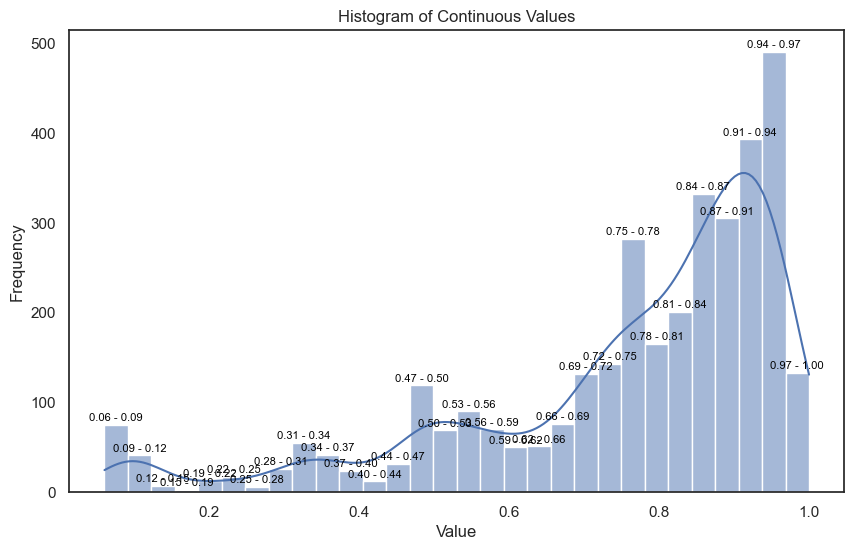

In [208]:
# Crear el histograma
plt.figure(figsize=(10, 6))
ax = sns.histplot(probabilidades_nuevos_datos['Probabilidad'], kde=True, bins=30)

# Añadir etiquetas con los valores de X a las barras
for p in ax.patches:
    # Obtener los bordes del bin
    bin_start = p.get_x()
    bin_end = bin_start + p.get_width()
    # Formatear el texto del rango
    label = f'{bin_start:.2f} - {bin_end:.2f}'
    # Posicionar la etiqueta en el centro de la barra, un poco por encima de la altura
    ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')

# Añadir etiquetas y título
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Continuous Values')

# Mostrar el gráfico
plt.show()

In [209]:
# ruta_output = os.path.join('C:/Users/nuvup/Documents')
# data_pred='predicciones_con_calibracion_isotonic_2024-05-23.geojson'

In [210]:
# # Se codifica las coordenadas al estandar 4326
# probabilidades_nuevos_datos = probabilidades_nuevos_datos.to_crs('4326')

# #Genera un archivo GeoJSON para su visualización de la predicción
# probabilidades_nuevos_datos.to_file(os.path.join(ruta_output,data_pred),  driver='GeoJSON')